Minimum diffusion DDPM training / generation code for personal understaning.  
For simplicity  
- data : MNIST with image shape (32, 32, 1)  
- model : simple ViT with time and class(digit number) embedding  
- no latent encoder such as VAE (i.e., non latent diffusion)  


In [1]:
from typing import Tuple, Any
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb

In [2]:
# Data Config
IMG_SHAPE = (1, 32, 32)

# Training Config
EPOCHS = 15
TRAIN_BATCH_SIZE = 64
LR = 3e-4
WEIGHT_DECAY = 1e-2

# Diffusion Config
STEPS = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Data Pereparation

In [3]:
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(IMG_SHAPE[1:]),
        torchvision.transforms.Normalize(0.5, 0.5),
    ]),
    download=True,
)
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:11<00:00, 900kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 65.6kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.47MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([1, 32, 32]) 5


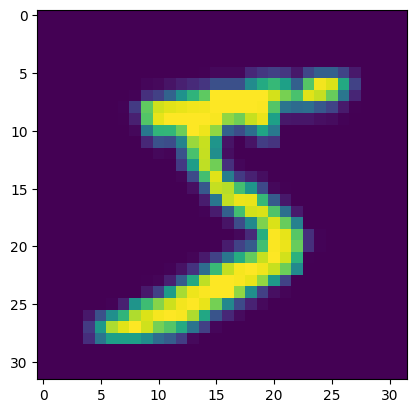

In [4]:
print(train_dataset[0][0].shape, train_dataset[0][1])
plt.imshow(train_dataset[0][0].squeeze().numpy())

## 2. Model

In [5]:
# Time Embedder (borrowed from micro diffusion)

class TimestepEmbedder(nn.Module):
    """Embeds scalar timesteps into vector representations.

    Args:
        hidden_size (int): Size of hidden dimension
        act_layer (Any): Activation layer constructor
        frequency_embedding_size (int, 512): Size of frequency embedding
    """
    def __init__(
        self,
        hidden_size: int,
        act_layer: Any = nn.SiLU,
        frequency_embedding_size: int = 512
    ):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            act_layer(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t: torch.Tensor, dim: int, max_period: int = 10000) -> torch.Tensor:
        """Create sinusoidal timestep embeddings."""
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(
                start=0,
                end=half,
                dtype=torch.float32,
                device=t.device
            ) / half
        )
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size).to(self.dtype)
        return self.mlp(t_freq)

    @property
    def dtype(self) -> torch.dtype:
        return next(self.parameters()).dtype

In [6]:
TimestepEmbedder(hidden_size=28*28).eval()(torch.arange(0, 1000)).detach().shape

torch.Size([1000, 784])

In [7]:
def modulate(x: torch.Tensor, shift: torch.Tensor, scale: torch.Tensor) -> torch.Tensor:
    """Applies modulation to input tensor using shift and scale factors."""
    return x * (1 + scale) + shift

In [64]:
class PatchEmbed(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim):
        super(PatchEmbed, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.conv = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # 入力画像のパッチ分割と埋め込み
        x = self.conv(x)  # (batch_size, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (batch_size, num_patches, embed_dim)
        return x


class ViTAutoencoder(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 1, patch_size = 4, embed_dim = 256, num_heads = 8, num_layers = 6, img_size = IMG_SHAPE):
        super(ViTAutoencoder, self).__init__()

        self.n_patches_h = (img_size[1] // patch_size)
        self.n_patches_w = (img_size[2] // patch_size)
        self.n_patches = self.n_patches_h * self.n_patches_w
        # エンコーダ部分
        self.patch_embed = PatchEmbed(in_channels, patch_size, embed_dim)  # (batch_size, num_patches, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # デコーダ部分
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(inplace=True),
            nn.Linear(embed_dim, embed_dim),
        )

        # 最後に元の画像サイズにリサイズする層
        self.decoder_conv = nn.ConvTranspose2d(embed_dim, out_channels, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # エンコーダ
        x = self.patch_embed(x)  # (batch_size, num_patches, embed_dim)

        # Transformerエンコーダに通す
        encoded = self.encoder(x)  # (batch_size, num_patches, embed_dim)

        # デコーダ
        decoded = self.decoder(encoded)  # (batch_size, num_patches, embed_dim)

        # 最後に画像のサイズに戻す
        decoded = decoded.transpose(1, 2)  # (batch_size, embed_dim, num_patches)
        output = decoded.view(decoded.size(0), decoded.size(1), self.n_patches_h, self.n_patches_w)  # (batch_size, embed_dim, n_patches_h, n_patches_w)
        output = self.decoder_conv(output)  # (batch_size, out_channels, H, W)

        return output


class ViTAutoencoderV2(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 1, patch_size = 4, embed_dim = 512, num_heads = 8, num_layers = 6, img_size = IMG_SHAPE):
        super(ViTAutoencoderV2, self).__init__()

        self.patch_size = patch_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        # エンコーダ部分
        self.patch_embed = PatchEmbed(in_channels, patch_size, embed_dim)  # (batch_size, num_patches, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # デコーダ部分
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(inplace=True),
            nn.Linear(embed_dim, patch_size * patch_size * out_channels),
        )

    def forward(self, x):
        # エンコーダ
        x = self.patch_embed(x)  # (batch_size, num_patches, embed_dim)

        # Transformerエンコーダに通す
        encoded = x + self.encoder(x)  # (batch_size, num_patches, embed_dim)

        # デコーダ
        decoded = self.decoder(encoded)  # (batch_size, num_patches, patch_size * patch_size * in_channels)

        # 最後に画像のサイズに戻す
        output = self.unpatchify(decoded)

        return output

    def unpatchify(self, x: torch.Tensor) -> torch.Tensor:
        """Reverses the patch embedding process to reconstruct the original image dimensions."""
        c = self.out_channels
        p = self.patch_size
        h = w = int(x.shape[1]**0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        return x.reshape(shape=(x.shape[0], c, h * p, h * p))

In [65]:
class DenoiseModel(torch.nn.Module):
    def __init__(
        self,
        img_shape: Tuple[int, int, int] = IMG_SHAPE,  # (ch, h, w)
        n_classes: int = 10,
        vit_denoiser_cls = ViTAutoencoder,
    ):
        super().__init__()
        self._img_shape = img_shape
        ch, h, w = img_shape
        self._n_classes = n_classes
        self._vit_denoiser = vit_denoiser_cls()
        self._timestep_embedder = TimestepEmbedder(hidden_size=ch*h*w)
        self._adaLN_modulation = nn.Sequential(
            nn.GELU(approximate="tanh"),
            nn.Linear(ch*h*w, 2 * ch*h*w, bias=True),
        )
        self._class_embedding = nn.Embedding(n_classes, ch*h*w)

    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """Given noisy input image x_t and time t, predict the added noise (x_t - x_t-1).

        Args:
            x (torch.Tensor): input noisy image x_t with shape (bs, ch, h, w)
            t (torch.Tensor): time steps with shape (bs,)
            y (torch.Tensor): class label with shape (bs,)

        Returns:
            torch.Tensor: Predicted added noise image (x_t - x_t-1) with shape (bs, ch, h, w)
        """
        bs, ch, h , w = x.shape
        assert self._img_shape == (ch, h, w)
        t_emb = self._timestep_embedder(t)  # (bs,) => (bs, c*h*w)
        class_emb = self._class_embedding(y)  # (bs,) => (bs, c*h*w)
        cond_emb = t_emb + class_emb
        shift, scale = self._adaLN_modulation(cond_emb).chunk(2, dim=1)
        shift = shift.reshape(bs, ch, h, w)  # (bs, ch*h*w) => (bs, ch, h, w)
        scale = scale.reshape(bs, ch, h, w)  # (bs, ch*h*w) => (bs, ch, h, w)
        x_t_fused = modulate(x, shift, scale)  # make x conditioned on timesteps and class
        added_noise = x - self._vit_denoiser(x_t_fused)
        return added_noise

In [58]:
_denoise_model = DenoiseModel(
    img_shape=IMG_SHAPE,
    vit_denoiser_cls=ViTAutoencoderV2,
).to(device).eval()

with torch.inference_mode():
    _out = _denoise_model(torch.randn(1, *IMG_SHAPE).to(device), torch.tensor([0.0]).to(device), torch.tensor([0]).to(device))
    print(_out.shape)

torch.Size([1, 1, 32, 32])


## 3. DDPM Scheduler Utils

In [27]:
def get_alpha_beta_sigma_scheduler(
    steps: int,
    # noise_beta = (0.5, 1.0),
    noise_beta = (0.0001, 0.02),
    device = device,
) -> Tuple[torch.Tensor, torch.Tensor]:
    b1, b2 = noise_beta
    beta_scheduler = [b1 + i*(b2-b1)/steps for i in range(steps)]
    alpha_scheduler = [1.0 - beta for beta in beta_scheduler]
    beta_scheduler = torch.tensor(beta_scheduler, device=device, dtype=torch.float32)
    alpha_scheduler = torch.tensor(alpha_scheduler, device=device, dtype=torch.float32)
    alpha_cumprod_scheduler = alpha_scheduler.cumprod(0)
    sigma_scheduler = (beta_scheduler * (1.0 - alpha_cumprod_scheduler.roll(1)) / (1.0 - alpha_cumprod_scheduler)).sqrt()
    sigma_scheduler[0] = 0.0
    return beta_scheduler.to(device), alpha_scheduler.to(device), alpha_cumprod_scheduler.to(device), sigma_scheduler.to(device)

In [28]:
beta_scheduler, alpha_scheduler, alpha_cumprod_scheduler, sigma_scheduler = get_alpha_beta_sigma_scheduler(steps=STEPS, noise_beta=(0.0001, 0.02))

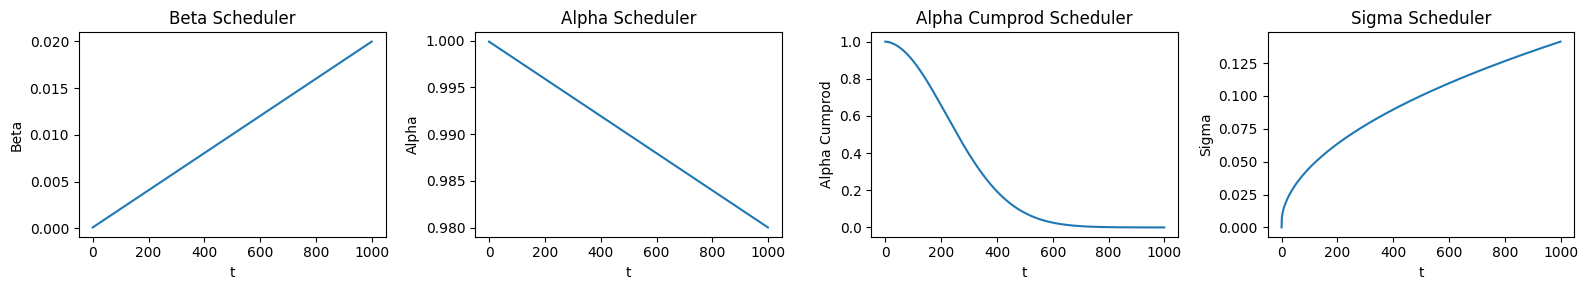

In [29]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(4*4, 3))

axes[0].plot(beta_scheduler.cpu().numpy())
axes[0].set_xlabel('t')
axes[0].set_ylabel('Beta')
axes[0].set_title('Beta Scheduler')

axes[1].plot(alpha_scheduler.cpu().numpy())
axes[1].set_xlabel('t')
axes[1].set_ylabel('Alpha')
axes[1].set_title('Alpha Scheduler')

axes[2].plot(alpha_cumprod_scheduler.cpu().numpy())
axes[2].set_xlabel('t')
axes[2].set_ylabel('Alpha Cumprod')
axes[2].set_title('Alpha Cumprod Scheduler')

axes[3].plot(sigma_scheduler.cpu().numpy())
axes[3].set_xlabel('t')
axes[3].set_ylabel('Sigma')
axes[3].set_title('Sigma Scheduler')

fig.tight_layout()

## 4. Denoise(generation) / Add Noise Utils

- Denoise (For Generation)

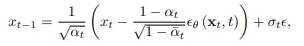

Following above equations, apply denoising process step by step to generate final image $x_0$ starting from pure noise $x_{t_{max}} \sim \mathcal{N}(0,\,1)$, where  
$\alpha_t=1-\beta_t$  
$\overline{\alpha}_{t} = \prod \alpha_t = \prod (1-\beta_t)$  
$ \sigma_{t}^2 = \frac{1.0 - \overline{\alpha}_{t-1}}{1.0 - \overline{\alpha}_{t}}\beta_t$  
$\epsilon_{\theta}(\boldsymbol{x}_{t}, t)$ : model output (predicted noise added to $x_t$)  
$\epsilon \sim \mathcal{N}(0,\,1)$


In [30]:
@torch.inference_mode()
def generate(
    denoise_model: nn.Module,
    classes: torch.Tensor,
    img_shape: Tuple[int, int, int] = IMG_SHAPE,
    steps: int = STEPS,
    beta_scheduler: torch.Tensor = beta_scheduler,
    alpha_scheduler: torch.Tensor = alpha_scheduler,
    alpha_cumprod_scheduler: torch.Tensor = alpha_cumprod_scheduler,
    sigma_scheduler: torch.Tensor = sigma_scheduler,
    debug: bool = False,
    device = device,
    return_only_final_image: bool = True,
) -> torch.Tensor:
    denoise_model.eval()
    # create initial pure noise x_tmax
    bs = len(classes)
    x_t = init_noise = torch.randn(bs, *img_shape).to(device)
    x_t_list = [x_t] if not return_only_final_image else None

    for t in reversed(range(1, steps)):
        # predict noise to denoise from x_t
        pred_noise = denoise_model(x_t, torch.tensor([t]).repeat((bs,)).to(device), classes.to(device))
        if debug:
            print('pred', (pred_noise.min(), pred_noise.max()), (x_t.min(), x_t.max()))
        # apply denoise equation above
        x_prev_t = x_t - pred_noise * (1 - alpha_scheduler[t]) / ((1 - alpha_cumprod_scheduler[t]).sqrt())
        x_prev_t /= alpha_scheduler[t].sqrt()
        x_prev_t += sigma_scheduler[t] * torch.randn_like(x_prev_t)
        x_t = x_prev_t
        if debug:
            print(x_prev_t.max())
        if not return_only_final_image:
            x_t_list.append(x_t)

    if return_only_final_image:
        x_0 = x_t  # generated image x_0  (n_generate, ch, h, w)
    else:
        x_0 = torch.stack(x_t_list, dim=0)  # (steps, n_generate, ch, h, w)
    return x_0

In [31]:
gen_img = generate(_denoise_model, debug=False, classes=torch.randint(0, 10, (1,)).to(device))
print(gen_img.shape)

torch.Size([1, 1, 32, 32])


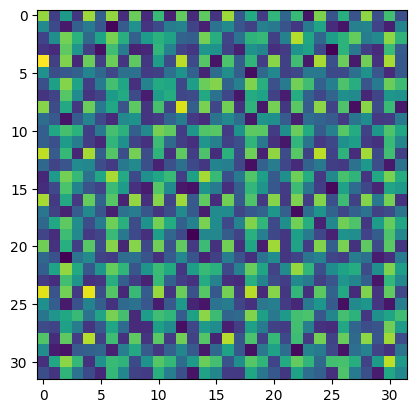

In [32]:
plt.imshow(gen_img[0].cpu().permute(1, 2, 0))

- Add Noise (For Training)

image.png

In [33]:
def add_noise(
    x_0: torch.Tensor,
    steps: int = STEPS,
    alpha_cumprod_scheduler: torch.Tensor = alpha_cumprod_scheduler,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Add noise corresponding to random time steps to ground-truth image x_0 to get x_t_rand

    Args:
        x (torch.Tensor): input ground-trueth image x_0 with shape (bs, ch, h, w)

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: noised added image x_t_rand, added noise, random timestepps correponsing to added noise
    """
    bs, ch, h, w = x_0.shape
    random_timesteps = torch.randint(0, steps, (bs,)).to(x_0.device)
    alpha_prod = alpha_cumprod_scheduler[random_timesteps].reshape((bs, 1, 1, 1))

    noise = torch.randn_like(x_0)
    x_noisy = x_0 * alpha_prod.sqrt() + noise * (1 - alpha_prod).sqrt()
    return x_noisy, noise, random_timesteps

In [34]:
_x_noisy, _noise, _random_timesteps = add_noise(next(iter(train_dataloader))[0].to(device))
print(_x_noisy.shape, _noise.shape, _random_timesteps.shape)

torch.Size([64, 1, 32, 32]) torch.Size([64, 1, 32, 32]) torch.Size([64])


## 4. Run Training

In [66]:
model = DenoiseModel(
    img_shape=IMG_SHAPE,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

epoch 0 : loss 0.08285444974899292


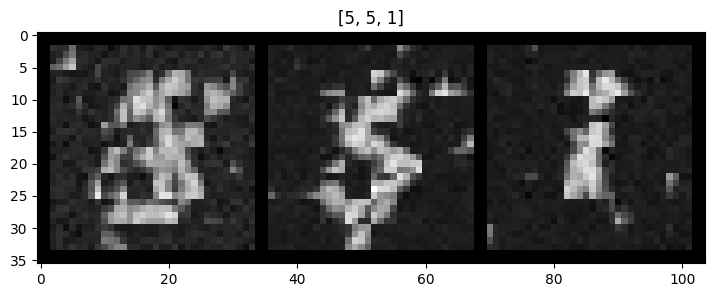

epoch 1 : loss 0.04723821207880974


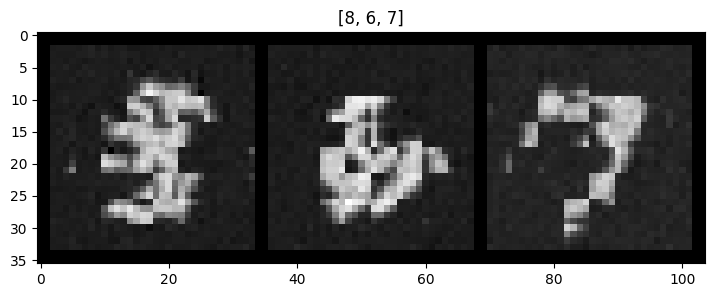

epoch 2 : loss 0.04408043622970581


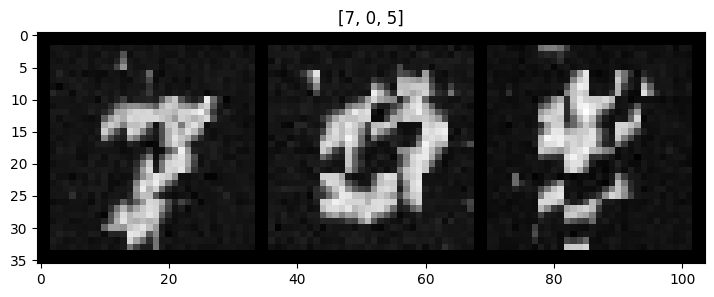

epoch 3 : loss 0.04239017143845558


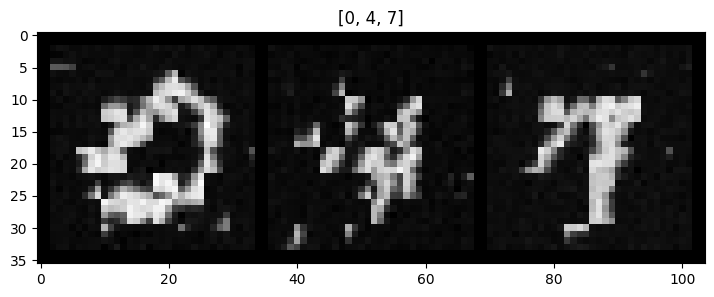

epoch 4 : loss 0.04093434289097786


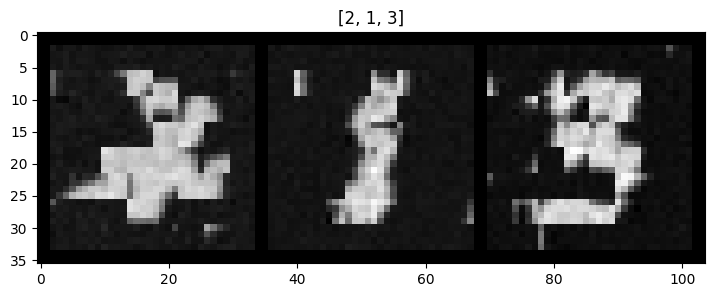

epoch 5 : loss 0.03952336311340332


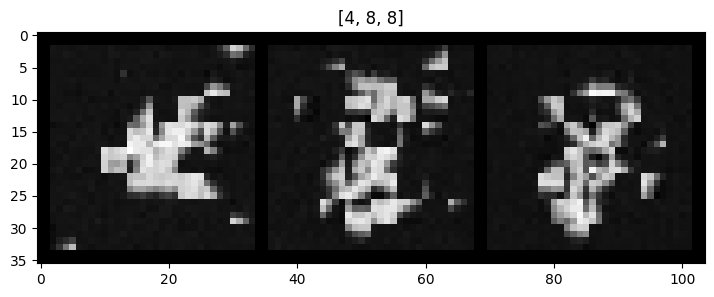

epoch 6 : loss 0.039602652192115784


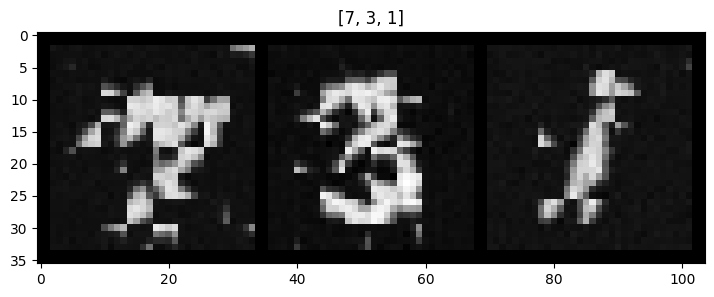

epoch 7 : loss 0.03833414986729622


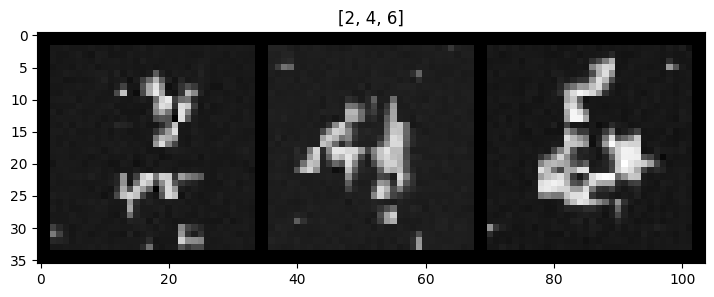

epoch 8 : loss 0.037926219403743744


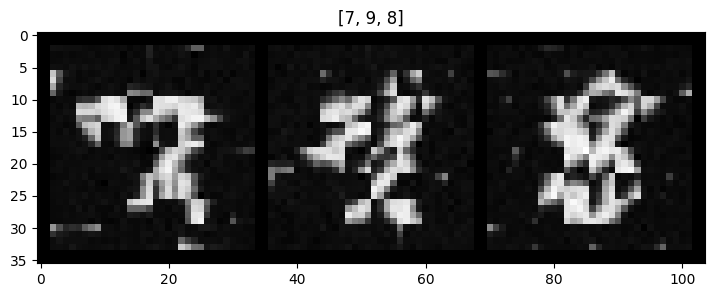

epoch 9 : loss 0.03739292174577713


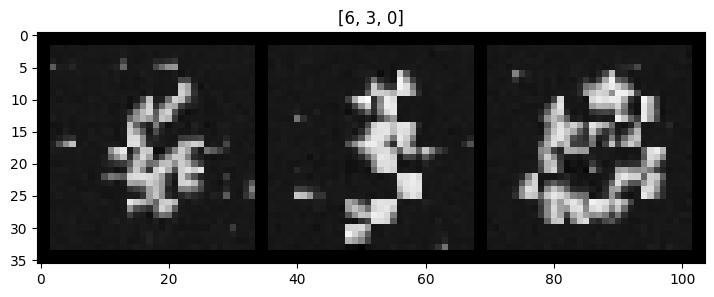

epoch 10 : loss 0.03723251447081566


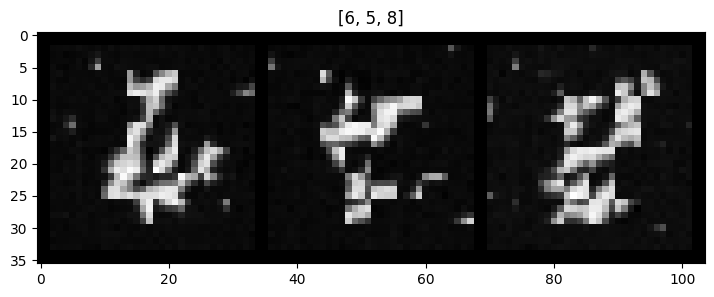

epoch 11 : loss 0.03606822341680527


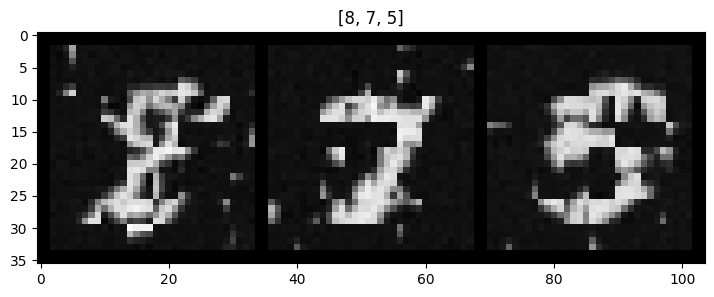

epoch 12 : loss 0.03642520681023598


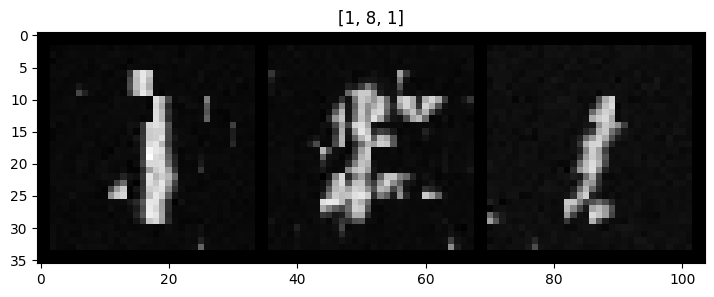

epoch 13 : loss 0.03586898744106293


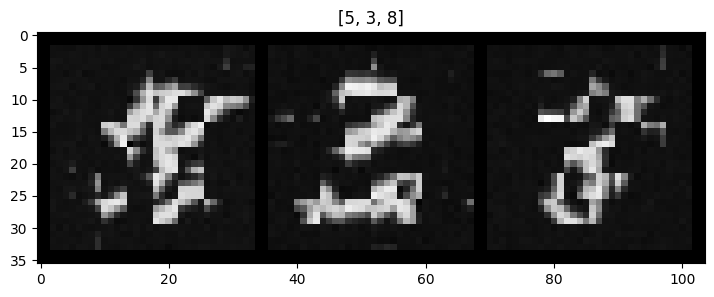

epoch 14 : loss 0.03574414551258087


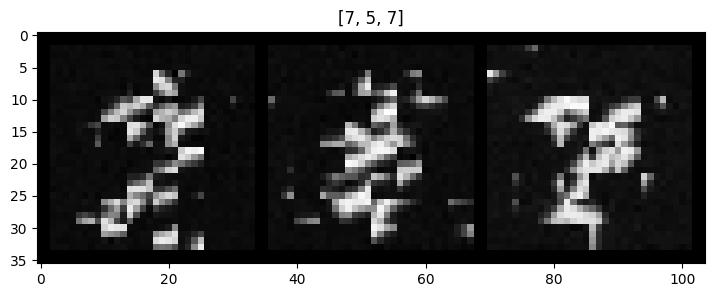

In [67]:
loss_history = []

for epoch in range(EPOCHS):
    # Train phase
    model.train()
    epoch_loss = 0.0
    for (batch_image, batch_class) in pb(train_dataloader):
        optimizer.zero_grad()
        batch_image = batch_image.to(device)
        batch_class = batch_class.to(device).long()
        x_noisy, noise, random_timesteps = add_noise(batch_image, steps=STEPS)  # (bs, ch, h, w), (bs, ch, h, w), (bs,)
        pred_noise = model(x_noisy, random_timesteps, y=batch_class)  # (bs, ch, h, w)
        loss = torch.nn.functional.mse_loss(pred_noise.cpu().float(), noise.cpu().float())
        if torch.isnan(loss):
            print('loss is nan')
            break
        loss.backward()
        optimizer.step()
        epoch_loss += loss.cpu().detach()
    loss_history.append(epoch_loss / len(train_dataloader))
    print(f'epoch {epoch} : loss {loss_history[-1]}')

    # Ealuluation Phase
    model.eval()
    classes = torch.randint(0, 10, (3,)).to(device)
    gen_img = generate(model, classes=classes)
    gen_img = (gen_img - gen_img.min()) / (gen_img.max() - gen_img.min())
    grid_image = torchvision.utils.make_grid(gen_img.cpu(), nrow=3)
    plt.figure(figsize=(3*3, 3))
    plt.imshow(grid_image.permute(1, 2, 0))
    plt.title(f'{classes.cpu().tolist()}')
    plt.show()

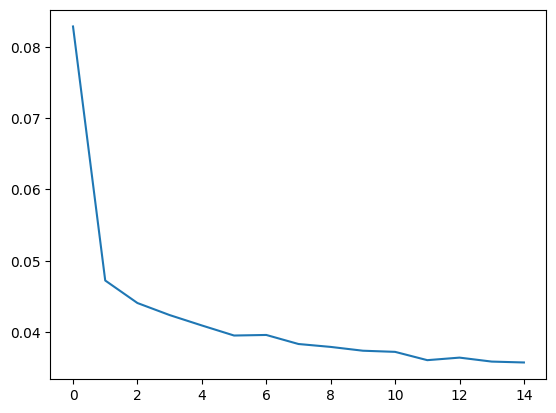

In [68]:
plt.plot(loss_history)

In [74]:
model2 = DenoiseModel(
    img_shape=IMG_SHAPE,
    vit_denoiser_cls=ViTAutoencoderV2,
).to(device)

optimizer = torch.optim.AdamW(model2.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

epoch 0 : loss 0.06722719967365265


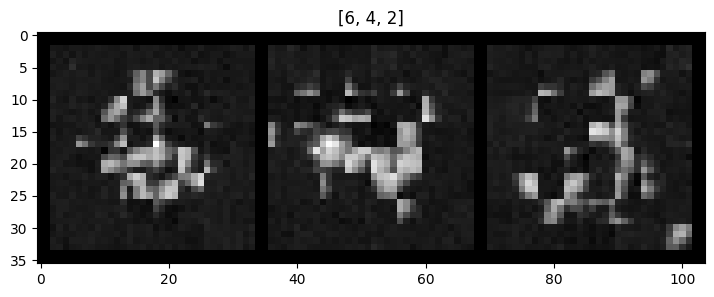

epoch 1 : loss 0.04692338779568672


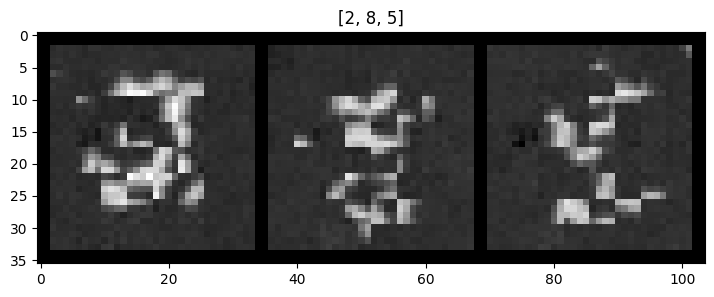

epoch 2 : loss 0.04354982078075409


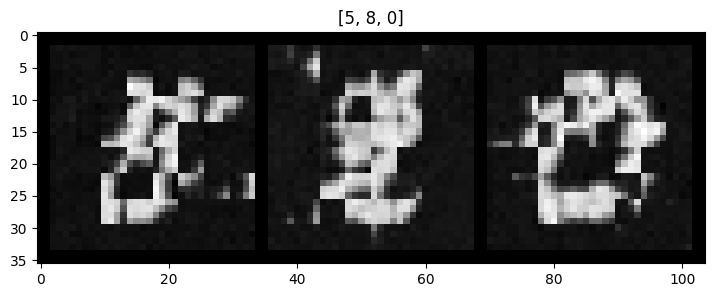

epoch 3 : loss 0.041427284479141235


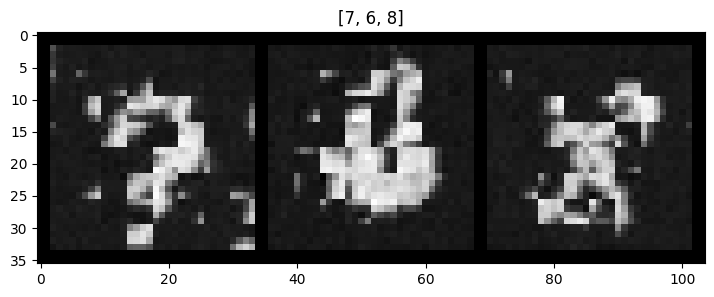

epoch 4 : loss 0.04002174735069275


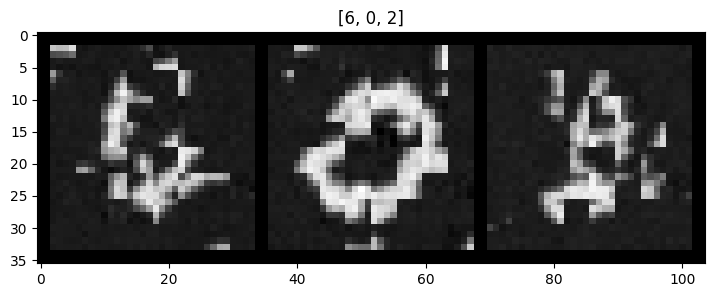

epoch 5 : loss 0.03972088173031807


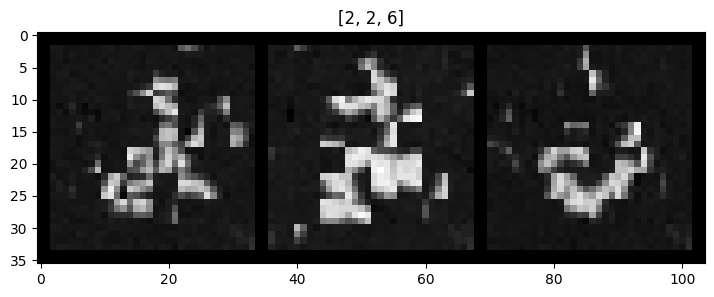

epoch 6 : loss 0.039160605520009995


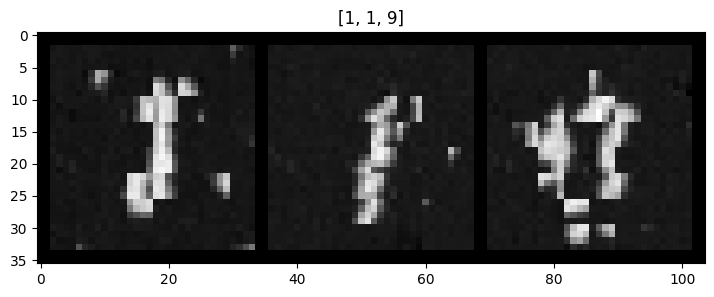

epoch 7 : loss 0.037782926112413406


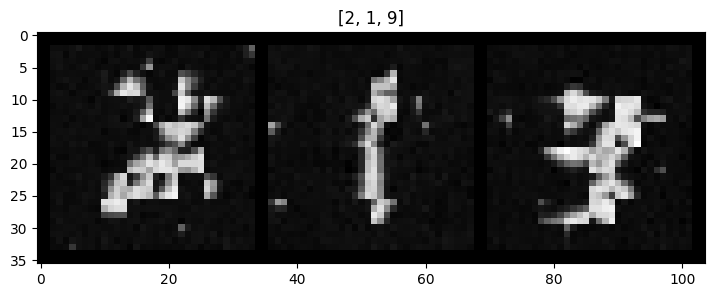

epoch 8 : loss 0.03747481852769852


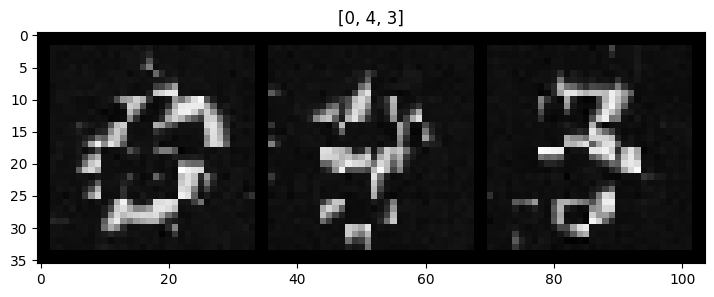

epoch 9 : loss 0.036624591797590256


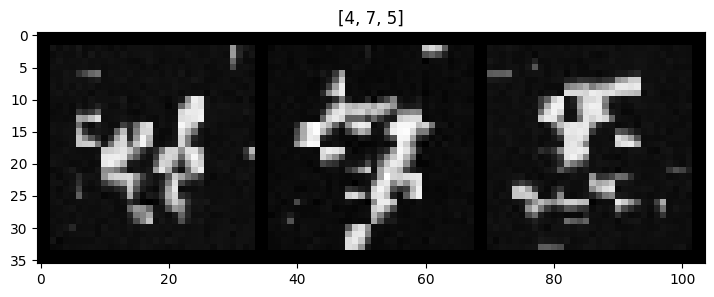

epoch 10 : loss 0.036319684237241745


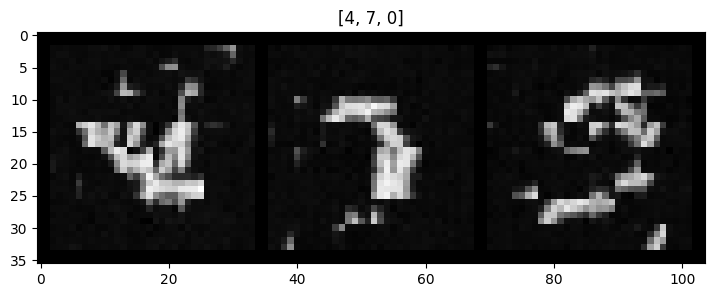

epoch 11 : loss 0.036067865788936615


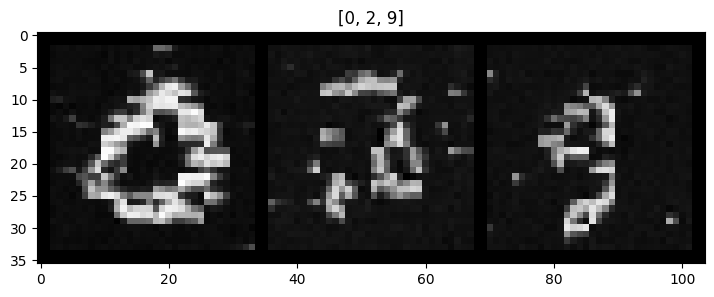

epoch 12 : loss 0.035166483372449875


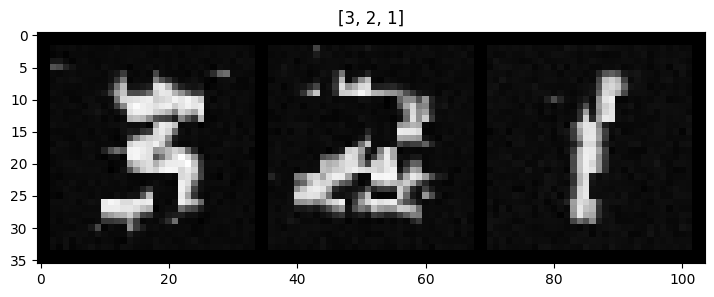

epoch 13 : loss 0.034198615700006485


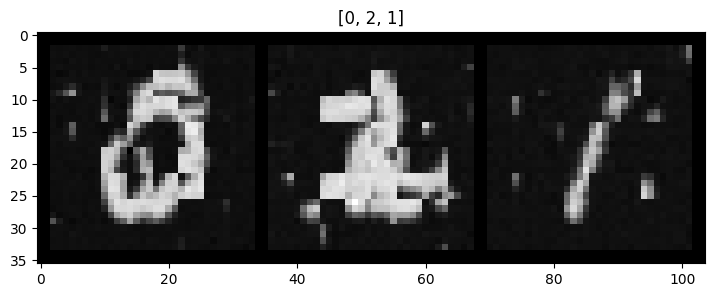

epoch 14 : loss 0.03400171548128128


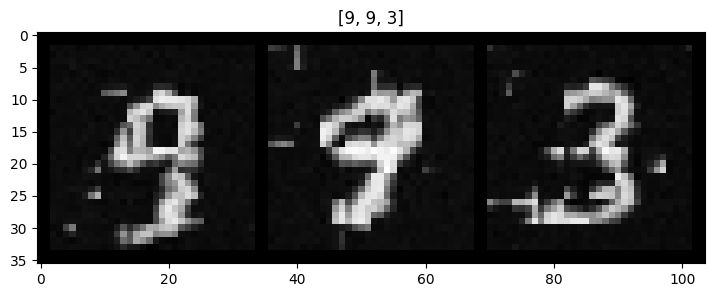

In [76]:
loss_history = []

for epoch in range(EPOCHS):
    # Train phase
    model2.train()
    epoch_loss = 0.0
    for (batch_image, batch_class) in pb(train_dataloader):
        optimizer.zero_grad()
        batch_image = batch_image.to(device)
        batch_class = batch_class.to(device).long()
        x_noisy, noise, random_timesteps = add_noise(batch_image, steps=STEPS)  # (bs, ch, h, w), (bs, ch, h, w), (bs,)
        pred_noise = model2(x_noisy, random_timesteps, y=batch_class)  # (bs, ch, h, w)
        loss = torch.nn.functional.mse_loss(pred_noise.cpu().float(), noise.cpu().float())
        if torch.isnan(loss):
            print('loss is nan')
            break
        loss.backward()
        optimizer.step()
        epoch_loss += loss.cpu().detach()
    loss_history.append(epoch_loss / len(train_dataloader))
    print(f'epoch {epoch} : loss {loss_history[-1]}')

    # Ealuluation Phase
    model2.eval()
    classes = torch.randint(0, 10, (3,)).to(device)
    gen_img = generate(model2, classes=classes)
    gen_img = (gen_img - gen_img.min()) / (gen_img.max() - gen_img.min())
    grid_image = torchvision.utils.make_grid(gen_img.cpu(), nrow=3)
    plt.figure(figsize=(3*3, 3))
    plt.imshow(grid_image.permute(1, 2, 0))
    plt.title(f'{classes.cpu().tolist()}')
    plt.show()

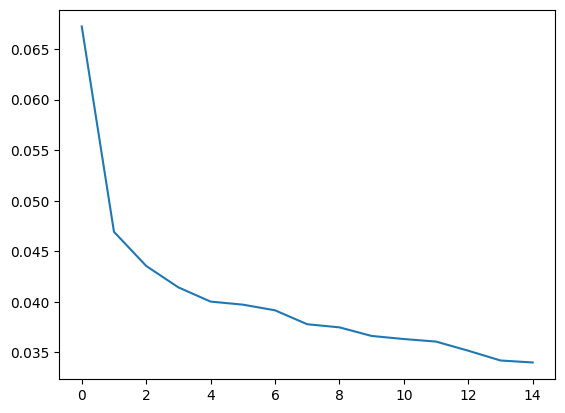

In [77]:
plt.plot(loss_history)

## 5. Generate Images with Trained Model

In [69]:
%%time
gen_img = generate(model, debug=False, classes=torch.arange(100).to(device).long() % 10)

CPU times: user 36.5 s, sys: 53 ms, total: 36.6 s
Wall time: 37 s


In [70]:
gen_img = (gen_img - gen_img.min()) / (gen_img.max() - gen_img.min())

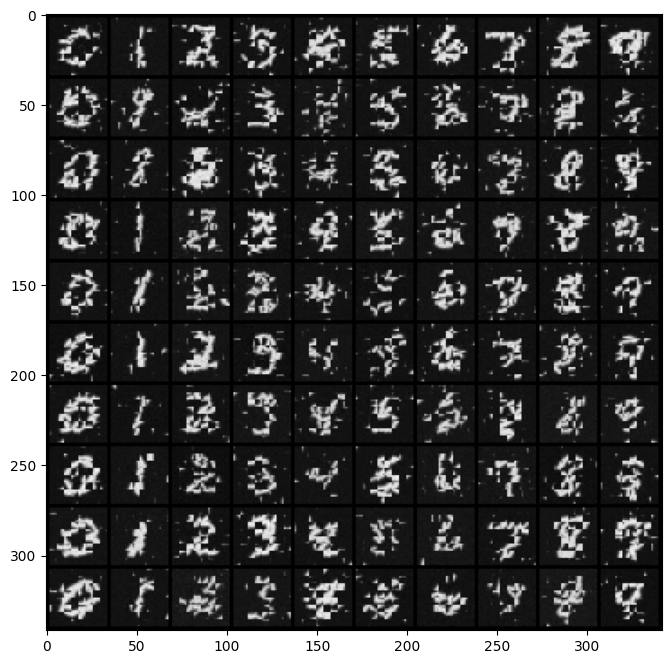

In [71]:
grid_image = torchvision.utils.make_grid(gen_img.cpu(), nrow=10)
plt.figure(figsize=(8, 8))
plt.imshow(grid_image.permute(1, 2, 0))

In [78]:
%%time
gen_img = generate(model2, debug=False, classes=torch.arange(100).to(device).long() % 10)

CPU times: user 1min 15s, sys: 105 ms, total: 1min 15s
Wall time: 1min 16s


In [79]:
gen_img = (gen_img - gen_img.min()) / (gen_img.max() - gen_img.min())

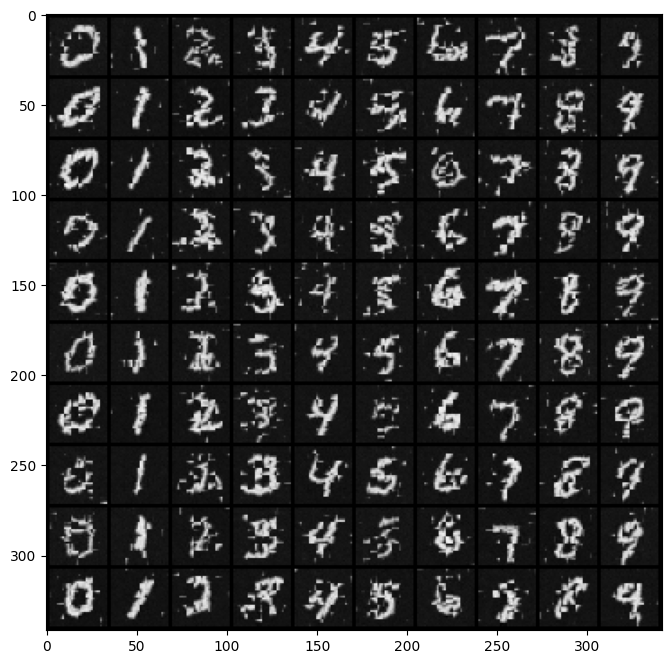

In [80]:
grid_image = torchvision.utils.make_grid(gen_img.cpu(), nrow=10)
plt.figure(figsize=(8, 8))
plt.imshow(grid_image.permute(1, 2, 0))

In [72]:
denoise_elapse_img = generate(model, debug=False, classes=torch.tensor([5]).to(device).long(), return_only_final_image=False)

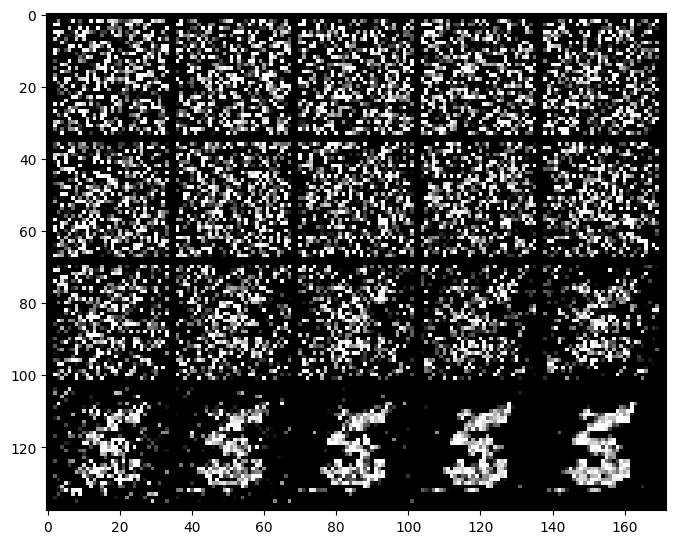

In [73]:
grid_image = torchvision.utils.make_grid(denoise_elapse_img[::50, 0].cpu(), nrow=5)
plt.figure(figsize=(8, 8))
plt.imshow(grid_image.permute(1, 2, 0))